### Test where we generate virtual shot gathers along line 2EW, which is perpendicular to the road

#### We might assume that the channel closest to the road should act as a virtual source of surface waves when a car is passing by

Again, this is based on the work of Dou et al. (2017). The aim is to identify times when cars pass the array by exloring the quality of the EGFs produced by stacking of the data. We might then be able to use the dispersion characteristics to to predict soil moisture variation

<img src="DAS_image1.png" alt="Drawing" style="width: 500px;"/>

<img src="DAS_image_3.png" alt="Drawing" style="width: 500px;"/>

In [2]:
import glob
import os
import numpy as np
import obspy as op
from obspy.signal.cross_correlation import correlate
import pandas as pd
import matplotlib.pyplot as plt
from ts_tools import spectralWhitening, despike, despike 
%matplotlib inline

#### Function to do spectral whitening: Just dividing the data by its amplitude spectrum

In [66]:
def whiten(trace):
    
    tr = trace.copy()
    w_dat = spectralWhitening(trace.data)
    tr.data = w_dat
    
    return tr

In [184]:
os.chdir("/Users/rmartinshort/Documents/Berkeley/Fiber_seismology/Met_data_predict")

In [68]:
all_data = pd.read_csv("Fnames_soilM_temp.csv")
lineEW = all_data[all_data['Line'] == "Line2EW"][['file_name','DateTime']]
#In this experiment we're only interested in the file names and the times


lineEW.reset_index(drop=True,inplace=True)
#Note that to avoid warning we should use assign to replace column values
lineEW.assign(DateTime = pd.to_datetime(lineEW['DateTime']).values)
otime = op.UTCDateTime(lineEW['DateTime'][0])
lineEW.set_index('DateTime',inplace=True)

#Generate linking column
lineEW = lineEW.assign(file_name=lineEW['file_name'].apply(lambda x: x[2:]))
fnames = list(lineEW['file_name'])

In [69]:
lineEW.head()

,file_name
DateTime,
2016-08-05 18:07:38,20160805180738_40_Hz_Line2EW.mseed
2016-08-05 18:08:38,20160805180838_40_Hz_Line2EW.mseed
2016-08-05 18:09:38,20160805180938_40_Hz_Line2EW.mseed
2016-08-05 18:10:38,20160805181038_40_Hz_Line2EW.mseed
2016-08-05 18:11:38,20160805181138_40_Hz_Line2EW.mseed


#### A test: Read one file, choose the virtual source to be the channel closest to the road. Cross correlate this source with all channels beyond 25 m from the road

In [70]:
#Location of the DAS data files
datadir = "/Volumes/Seagate Expansion Drive/DAS_data"
cwd = os.getcwd()
os.chdir(datadir)

In [71]:
f = op.read('20160805181538_40_Hz_Line2EW.mseed',format='mseed')
f = f.detrend('demean')
f = f.detrend('linear')
rev_f = list(reversed(f))

In [72]:
start_trace = 25

In [73]:
#use the first trace as the virtual source
f0 = whiten(rev_f[0])
nchan = len(rev_f)
shift = len(f0.data)
#cross correlate the virtual source with itself
fc = correlate(f0,f0,shift)
X = np.linspace(-60,60,2*shift+1)
Xcorr_mat = np.zeros([len(fc),nchan-start_trace])
Xcorr_mat[:,0] = fc

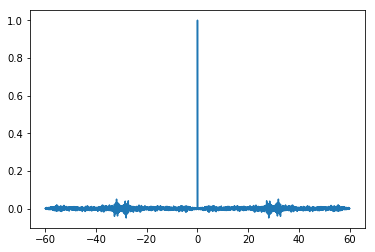

In [74]:
#Cross correlation of virtual source with itself
plt.plot(X,fc)

In [75]:
nchan

51

In [76]:
np.shape(Xcorr_mat)

(4097, 26)

#### Correlate all traces over this 1 minute timespan and display

In [77]:
j = 0
for i in range(start_trace,nchan):
    fc = correlate(f0,whiten(rev_f[i]),shift)
    Xcorr_mat[:,j] = fc
    j += 1

(-1, 1)

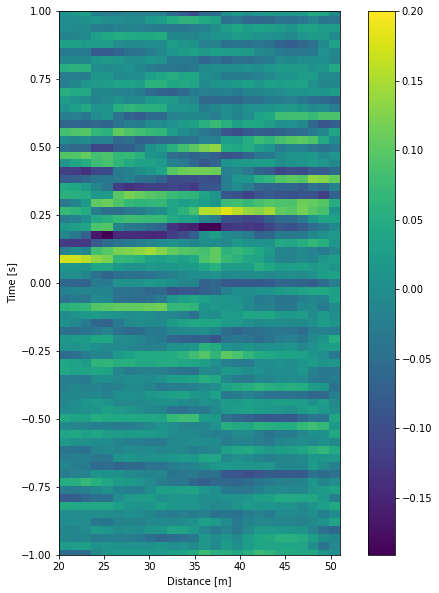

In [78]:
plt.figure(figsize=(10,10))
plt.imshow(Xcorr_mat,aspect=30,extent=[20,nchan,-60,60],vmax=0.2,interpolation='nearest')
plt.colorbar()
plt.xlabel('Distance [m]')
plt.ylabel('Time [s]')
plt.ylim([-1,1])

#### Testing the Dou et al. 2017 QC proceedure for surface waves
>  Determine RMS amplitude as a function of channel offset from the road 

>  Fit a power law curve of the type a + b*x^(c) (doesn't work well? Removal of b gives better results) 

>  We would expect c to be roughly equal to -2 if there is a source of surface waves from the road   

>  Find the correlation coefficient between the power law prediction and the observation  

>  Compute abs(c*R+2). If this is less than 1, we have a good source of surface waves  


In [155]:
from scipy.optimize import curve_fit
from scipy.stats import pearsonr

def func_powerlaw(x,m,a):
    
    return a*(x**m)

target_func = func_powerlaw

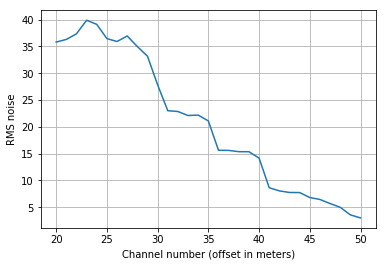

In [180]:
chan_n = np.zeros(nchan-start_trace)
rms_vals = np.ones(nchan-start_trace)
offset = start_trace
j = 0 

for i in range(start_trace,nchan):
    tr = rev_f[i]
    x = tr.data
    rms_noise = np.sqrt(np.mean(x*x))
    rms_vals[j] = rms_noise
    chan_n[j] = i
    j += 1 

plt.plot(chan_n,rms_vals)
plt.xlabel('Channel number (offset in meters)')
plt.ylabel('RMS noise')
plt.grid()

In [181]:
rms_vals[0]

35.82019742856326

In [172]:
popt, pcov = curve_fit(target_func,chan_n,rms_vals,xtol=1e-2,maxfev=1500)

In [173]:
popt

array([ -1.75344413, 227.28375874])

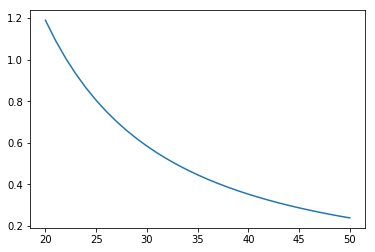

In [174]:
x = chan_n
y = popt[1]*x**popt[0]
plt.plot(x,y)

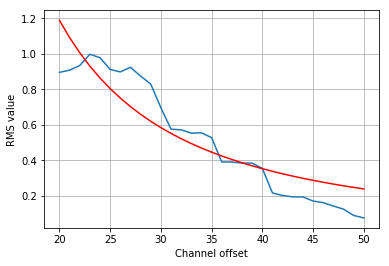

In [175]:
plt.plot(chan_n,rms_vals)
plt.plot(chan_n,target_func(chan_n,*popt),'r-')
plt.xlabel('Channel offset')
plt.ylabel('RMS value')
plt.grid()

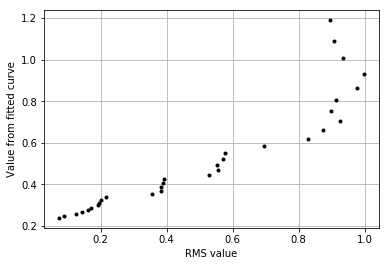

In [176]:
plt.plot(rms_vals,target_func(chan_n,*popt),'k.')
plt.xlabel('RMS value')
plt.ylabel('Value from fitted curve')
plt.grid()

In [185]:
corr_coef = pearsonr(rms_vals,target_func(chan_n,*popt))[0]
optval = abs(popt[0]*corr_coef + 2)
print(optval)
print(corr_coef)

0.3944342133594654
0.9156640704844758


#### Ran production code to calculate these scores for every minute chunk of data. The idea is then to select just those that have QC scores of less than 1, stack them and cross correlate

In [186]:
mv_scores = pd.read_csv('Line_2EW_QC_scores.dat')

In [187]:
mv_scores.describe()

,QC_scores,c_vals,corr_coefs
count,20000.000000,20000.000000,20000.000000
mean,1.080828,-1.116137,0.754160
std,0.451679,0.541026,0.209659
min,0.002655,-9.257493,0.000454
25%,0.791098,-1.411222,0.772038
50%,0.925592,-1.283912,0.835934
75%,1.215327,-1.017047,0.866555
max,5.814082,3.277476,0.997389


In [215]:
good_QC = mv_scores[mv_scores['QC_scores'] < 1]

In [216]:
len(good_QC)/len(mv_scores)

0.18662935419533389

In [217]:
len(good_QC)

12071

In [218]:
#Location of the DAS data files
datadir = "/Volumes/Seagate Expansion Drive/DAS_data"
cwd = os.getcwd()
os.chdir(datadir)

In [219]:
good_QC.reset_index(inplace=True)

In [220]:
good_QC.head()

,index,file_name,DateTime,QC_scores,c_vals,corr_coefs
0,0,20160805180738_40_Hz_Line2EW.mseed,2016-08-05 18:07:38,0.506591,-1.650323,0.904919
1,1,20160805180838_40_Hz_Line2EW.mseed,2016-08-05 18:08:38,0.787695,-1.436849,0.843725
2,2,20160805180938_40_Hz_Line2EW.mseed,2016-08-05 18:09:38,0.568146,-1.592720,0.898999
3,3,20160805181038_40_Hz_Line2EW.mseed,2016-08-05 18:10:38,0.670573,-1.476272,0.900530
4,6,20160805181338_40_Hz_Line2EW.mseed,2016-08-05 18:13:38,0.453823,-1.704376,0.907180


In [221]:
### Lets do a simple stack of the data that we've selected here

fnames = good_QC['file_name']
start_trace = 20

fcount = 0
for infile in list(fnames[:200]):
    print(infile)
    
    f = op.read(infile,format='mseed')
    #f.filter('bandpass',freqmin=2,freqmax=20)
    f.detrend('demean')
    f.detrend('linear')
    rev_f = list(reversed(f))
    nchan = len(rev_f)
    
    trace = rev_f[0]
    
    if not np.isnan(trace.data).any():
        
        try:
        
           shift = trace.stats.npts
        
           if fcount == 0:
            
               f0 = trace
               fc = correlate(f0,f0,int(shift))
               Xcorr_mat = np.zeros([len(fc),nchan-start_trace])
            
               j = 0 
               for i in range(start_trace,nchan):
                   fi = rev_f[i]
                   fc = correlate(f0,fi,int(shift))
                   Xcorr_mat[:,j] = fc
                   j += 1
        
           else:
            
               f0 = whiten(rev_f[0])
            
               j = 0
               for i in range(start_trace,nchan):
                   fc = correlate(f0,whiten(rev_f[i]),int(shift))
                   Xcorr_mat[:,j] += fc
                   j += 1
                                      
           fcount += 1
        
        except:
            
            print("Issue in cross correlating file %s" %infile)
    
    else:
        
        print("Spike detected in %s: moving on" %infile)

Xcorr_mat = Xcorr_mat/fcount

20160805180738_40_Hz_Line2EW.mseed
20160805180838_40_Hz_Line2EW.mseed
20160805180938_40_Hz_Line2EW.mseed
20160805181038_40_Hz_Line2EW.mseed
20160805181338_40_Hz_Line2EW.mseed
20160805181438_40_Hz_Line2EW.mseed
20160805181538_40_Hz_Line2EW.mseed
20160805182238_40_Hz_Line2EW.mseed
20160805182738_40_Hz_Line2EW.mseed
20160805183038_40_Hz_Line2EW.mseed
20160805183138_40_Hz_Line2EW.mseed
20160805183238_40_Hz_Line2EW.mseed
20160805183338_40_Hz_Line2EW.mseed
Issue in cross correlating file 20160805183338_40_Hz_Line2EW.mseed
20160805193523_40_Hz_Line2EW.mseed
20160805193623_40_Hz_Line2EW.mseed
20160805193723_40_Hz_Line2EW.mseed
20160805194323_40_Hz_Line2EW.mseed
20160805194423_40_Hz_Line2EW.mseed
20160805194523_40_Hz_Line2EW.mseed
20160805194623_40_Hz_Line2EW.mseed
20160805194923_40_Hz_Line2EW.mseed
20160805195023_40_Hz_Line2EW.mseed
20160805195123_40_Hz_Line2EW.mseed
20160805195223_40_Hz_Line2EW.mseed
20160805195323_40_Hz_Line2EW.mseed
20160805195423_40_Hz_Line2EW.mseed
20160805195523_40_Hz_Li

(-0.5, 0.5)

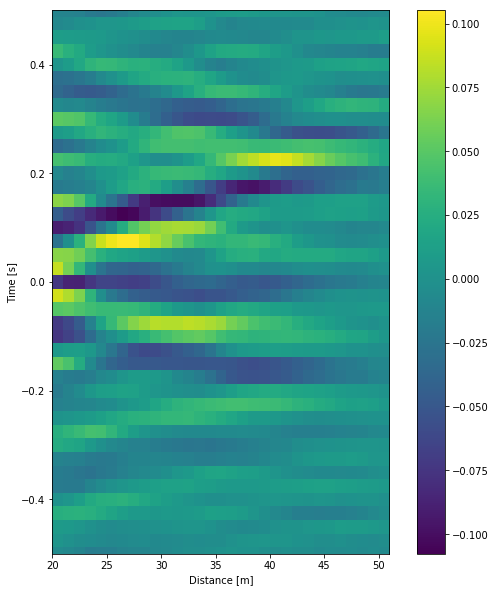

In [222]:
plt.figure(figsize=(10,10))
plt.imshow(Xcorr_mat,aspect=50,extent=[start_trace,nchan,-60,60])
plt.colorbar()
plt.xlabel('Distance [m]')
plt.ylabel('Time [s]')
plt.ylim([-0.5,0.5])

Unfortunately this does not look like very much. Maybe the criteria we're using for the rms moveout test isn't working properly?